In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import plotly.io as pio
pio.renderers.default = "svg"

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
%%script false --no-raise-error
filename = "../../../pylec/studies/data/Synthetic.Household.Profiles.h5"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df = pd.read_hdf(filename, "TimeSeries")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    houseinfo = pd.read_hdf(filename, "HouseInfo")
mask = (houseinfo.Country == "France") & (houseinfo.Nmonths == "12")
df = df.loc[:, [str(a) for a in houseinfo[mask].pdIndex.tolist()]]

df["Index"] = pd.date_range(
    start="01-01-2019 00:00:00", end="31-12-2019 23:45:00", freq="15T"
)
df.set_index("Index", drop=True, inplace=True)

# --------------------------------------------
dateparse = lambda x: datetime.strptime(x, '%Y%m%d:%H%M')
pv = pd.read_csv("Timeseries_44.931_4.896_SA_1kWp_crystSi_14_38deg_-3deg_2014_2015.csv",
                 parse_dates=[0], index_col=[0], header=8, skipfooter=13, engine='python',
                 date_parser=dateparse)
# P is in W for a 1kW PV so we just have to change it to kW to get the coef 
pv = pv[['P']] / 1000
pv.columns = ["pv_1kw"]
pv = pv.loc['2014-01-01 00:00:00':'2015-01-01 00:10:00', :]

# Shifting things by 11 min, but whatever.
pv['Index'] = pd.date_range(start='2019-01-01 00:00:00',
                            end='2020-01-01 00:00:00', freq='60T')
pv.set_index('Index', drop=True, inplace=True)

# Interpolating to get 15-min interval values
pv = pv.resample('15T').interpolate('time')
pv.drop(pv.tail(1).index, inplace=True)

# --------------------------------------------
df["pv_1kw"] = pv["pv_1kw"]
df.to_pickle("fr_quoilin_data_valence.pickle")

In [3]:
df = pd.read_pickle("fr_quoilin_data_valence.pickle")
df.head()

,2000900,2000901,2000903,2000904,2000905,2000906,2000907,2000908,2000909,2000910,...,2001188,2001189,2001190,2001192,2001193,2001194,2001195,2001197,2001199,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.295204,0.327625,0.483190,0.687899,0.143035,0.221557,0.224354,0.348925,2.359406,0.116382,...,0.079687,0.757643,0.080509,0.546715,0.026350,0.145583,0.160894,0.079701,1.420406,0.0
2019-01-01 00:15:00,0.223572,0.519240,0.236277,0.976978,0.178788,0.245871,0.485754,0.131845,1.064770,0.102974,...,0.269552,1.211409,0.074367,0.528931,0.057051,0.128810,0.155660,0.113194,0.641011,0.0
2019-01-01 00:30:00,0.237445,0.397812,0.151005,0.742844,0.232710,0.277901,0.594242,0.080997,0.897831,0.068910,...,0.107144,1.195561,0.083457,0.640498,0.069793,0.086199,0.188493,0.086067,0.540511,0.0
2019-01-01 00:45:00,0.477201,0.397999,0.398284,0.587097,0.285982,0.267720,0.512216,0.141001,1.433766,0.063750,...,0.165818,1.145802,0.107888,0.544124,0.060159,0.079745,0.160131,0.068022,0.863154,0.0
2019-01-01 01:00:00,0.415664,0.275134,0.108359,0.789470,0.181792,0.258787,0.185333,0.127379,1.140404,0.069257,...,0.250045,1.544101,0.036674,0.560161,0.031038,0.084432,0.178843,0.090153,0.814874,0.0


# Set study on 20 households

In [4]:
nb_houses = 20

In [5]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")
df.head()

Average consumption is 5.56 MWh


,2000989,2001197,2000914,2001123,2000964,2001189,2001111,2001179,2000909,2000918,...,2001107,2000913,2001139,2000960,2001149,2001165,2000954,2001114,2000926,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.420397,0.079701,0.857910,0.031886,0.181189,0.757643,0.190965,0.227143,2.359406,0.055817,...,0.070520,0.142502,0.255521,0.582962,0.180451,1.942729,3.863059,0.121460,0.469955,0.0
2019-01-01 00:15:00,0.545898,0.113194,1.250317,0.141971,0.137223,1.211409,0.093381,0.188724,1.064770,0.061609,...,0.088147,0.223753,0.345453,0.525038,0.200254,3.050416,5.486453,0.134062,0.684911,0.0
2019-01-01 00:30:00,0.434237,0.086067,1.391707,0.100812,0.145738,1.195561,0.059680,0.132277,0.897831,0.050262,...,0.114732,0.041090,0.326808,1.252299,0.226341,0.560178,4.171616,0.109371,0.762364,0.0
2019-01-01 00:45:00,0.282571,0.068022,1.058611,0.039150,0.292894,1.145802,0.157409,0.154381,1.433766,0.044647,...,0.140997,0.281691,0.546796,0.521619,0.218049,3.840278,3.296981,0.097153,0.579897,0.0
2019-01-01 01:00:00,0.269873,0.090153,0.930174,0.074543,0.215576,1.544101,0.051027,0.251023,1.140404,0.037189,...,0.085866,0.043304,0.188321,0.512975,0.145118,0.313930,4.377657,0.073465,0.317332,0.0


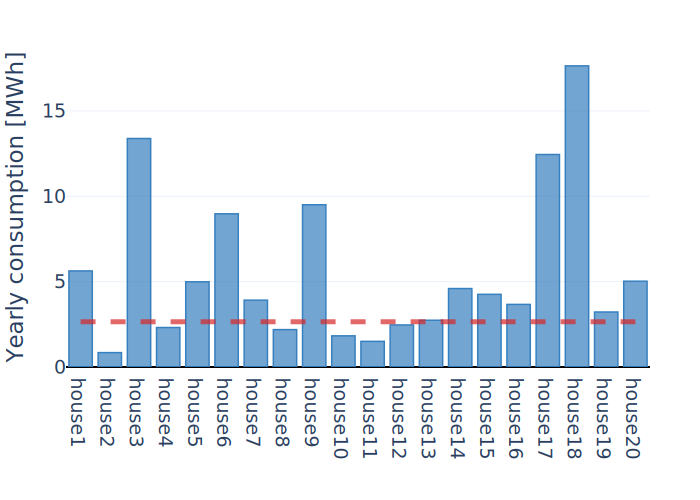

In [6]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house20",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

In [7]:
df.describe().T[["mean", "min", "max"]]

,mean,min,max
2000989,0.642409,0.009760,15.452793
2001197,0.096313,0.002070,2.248960
2000914,1.527877,0.007914,73.415019
2001123,0.264018,0.010254,8.702582
2000964,0.569726,0.018387,17.223078
2001189,1.024281,0.014418,34.618334
2001111,0.446941,0.011408,9.133565
2001179,0.250011,0.008664,4.353821
2000909,1.084943,0.015853,23.098691
2000918,0.208345,0.004761,7.726401


In [8]:
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

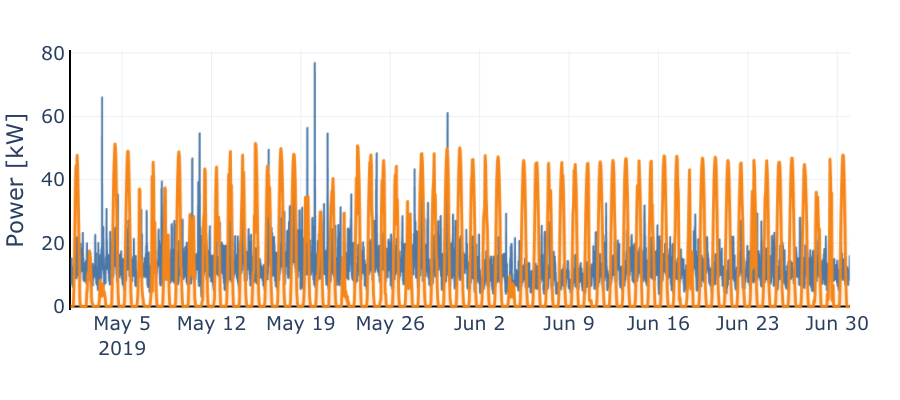

In [9]:
graph = df.loc["2019-05-01 00:00:00":"2019-07-01 00:00:00", :].copy()
graph.pv_1kw *= nb_houses * 3

fig = px.line(graph, y=["community_kW", "pv_1kw"])
fig.data[1].update(fill="tozeroy", line_width=3,
                   fillcolor="rgba(255, 127, 14, 0.1)")
fig.update_layout(
    layout,
    height=400,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black')
fig.show(renderer="png")

In [10]:
def self_consumption_production(df, cons_col, prod_col, timing):
    """Return self-consumption and self-production in %"""
    result = {}
    local = df[[cons_col, prod_col]].groupby(pd.Grouper(freq=timing)).sum().min(axis=1).sum()  # unit do not matter
    result[f"self_cons"] = local * 100 / df[prod_col].sum()
    result[f"self_prod"] = local * 100 / df[cons_col].sum()
    return result

In [11]:
pv_sizes = list(np.linspace(0.1, 5, 100))
self_prod = {}
self_cons = {}
for timing in ["15T", "365D"]:
    self_prod[timing] = []
    self_cons[timing] = []
    for pv_size in pv_sizes:
        graph = df.copy()
        graph.pv_1kw *= nb_houses * pv_size
        res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing=timing)
        self_prod[timing].append(res['self_prod'])
        self_cons[timing].append(res['self_cons'])

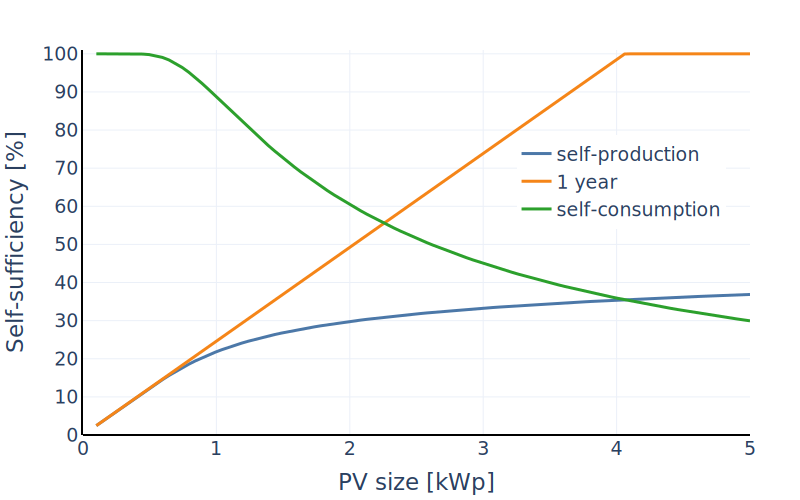

In [12]:
graph = pd.DataFrame(index=pv_sizes, data=self_prod)
graph2 = pd.DataFrame(index=pv_sizes, data=self_cons)
graph2 = graph2[["15T"]]
graph.columns = ["self-production", "1 year"]
graph2.columns = ["self-consumption"]
_fig = px.line(graph)
_fig.add_traces(px.line(graph2).data[0])
_fig.update_traces(line_width=3)
_fig.data[-1].update(line_color="rgba(44, 160, 44, 1.0)")
_fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Self-sufficiency [%]",
    yaxis_dtick=10,
    xaxis_title="PV size [kWp]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_range=[0, 101],
    xaxis_range=[0, 5],
    showlegend=True,
    legend={"x": 0.65, "y": 0.78},
    legend_title="")
_fig.show()

In [33]:
_fig.write_image("results/meaning_of_NSS.svg")

# Select a day

In [13]:
df = df.loc["2019-06-11 00:00:00":"2019-06-11 23:45:00", :]
df["weight"] = [1.0] * len(df)
df.head()

,pv_1kw,community_kW,weight
Index,,,
2019-06-11 00:00:00,0.0,6.132813,1.0
2019-06-11 00:15:00,0.0,5.537561,1.0
2019-06-11 00:30:00,0.0,7.819171,1.0
2019-06-11 00:45:00,0.0,7.992664,1.0
2019-06-11 01:00:00,0.0,9.830049,1.0


PV that produces all energy consumption would be 44.85 kWp
Self-consumption = 42.06 % 
Self-sufficiency = 42.06 %


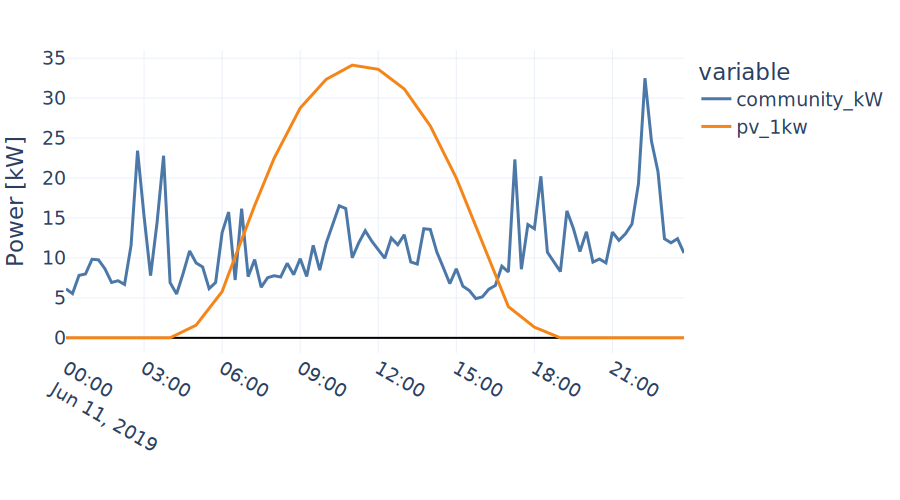

In [14]:
breakpoint_pv = df["community_kW"].sum() / df["pv_1kw"].sum()
print(f"PV that produces all energy consumption would be {round(breakpoint_pv, 2)} kWp")

graph = df.loc[:, ["community_kW", "pv_1kw"]].copy()
graph.pv_1kw *= breakpoint_pv
res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing="15T")
print(f"Self-consumption = {round(res['self_cons'], 2)} % \nSelf-sufficiency = {round(res['self_prod'], 2)} %")

fig = px.line(graph)
fig.update_traces(line_width=3)
fig.update_layout(layout, width=900, yaxis_title="Power [kW]", xaxis_title="")
fig.show()

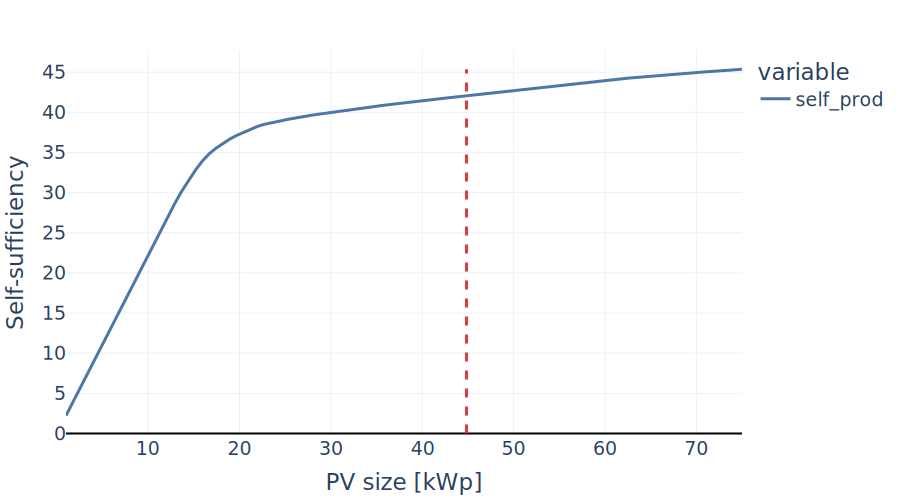

In [15]:
pv_sizes = list(np.linspace(1, 1.5 * 50, 100))
self_prod = []
for pv_size in pv_sizes:
    graph = df.copy()
    graph.pv_1kw *= pv_size
    res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw",  timing="15T")
    self_prod.append(res['self_prod'])

graph = pd.DataFrame(index=pv_sizes, data={"self_prod": self_prod})
fig = px.line(graph)
fig.update_traces(line_width=3)
fig.update_layout(layout, width=900, yaxis_title="Self-sufficiency", xaxis_title="PV size [kWp]")
fig.add_shape(
  type='line',
  x0=breakpoint_pv, x1=breakpoint_pv, y0=0, y1=graph.self_prod.max(),
  line={'dash': 'dash', 'width': 3,
        'color': 'rgba(214, 39, 40, 0.9)'})
fig.show()

# Natural self-sufficiency is defined when `energy consumed = energy produced`

Building a new "profile".

$$
\Large profile(t) = consumption(t) + profile_{change}(t) \\
\Large 0 \leq profile(t) \leq \max(consumption(t)) \\
\Large \sum^T_t profile_{change}(t) \times weight(t) = 0 \\
$$

Calculating self-sufficiency (turns the problem into a MILP).

$$
\Large grid^+(t) - grid^-(t) = profile(t) - pv \times irradiance(t) \\
\Large 0 \leq grid^+(t) \leq \delta \times \max(consumption(t)) \\
\Large 0 \leq grid^-(t) \leq (1 - \delta ) \times pv \times irradiance(t) \\
\Large \frac{\sum^T_t weight(t) \times grid^+(t)}{\sum^T_t weight(t) \times consumption(t)} = 1 - target^{self} \\
$$

Objective function
$$
\Large \sum^T_t weight(t) \times profile_{change}(t)^2 \\
$$

In [16]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass


class ProfileGenerator():
    verbose: bool = False
    solver: str = "gurobi"
    time_limit: int = 5 * 60
    peak_load: float = 50. # <--- Enforce peak load here

    def solve(self, df, col_conso, col_prod, col_weight, pv_size, target):
        # Inputs format
        energy_cons = (df[col_conso] * df[col_weight]).sum()
        #self.peak_load = 10 * float(df.loc[:, col_conso].max())
        cons = df.loc[:, [col_conso]].copy().reset_index()[col_conso].to_dict()
        irradiance = df.loc[:, [col_prod]].copy().reset_index()[col_prod].to_dict()
        weight = df.loc[:, [col_weight]].copy().reset_index()[col_weight].to_dict()
        
        # Model parameters
        m = ConcreteModel()
        m.horizon = Set(initialize=list(cons.keys()), ordered=True)
        
        # Variables to match a given self-sufficiency
        m.profile_change = Var(m.horizon)
        m.profile = Var(m.horizon, domain=NonNegativeReals)
        m.grid_plus = Var(m.horizon, domain=NonNegativeReals)
        m.grid_minus = Var(m.horizon, domain=NonNegativeReals)
        m.delta = Var(m.horizon, domain=Binary)
        
        # Constraints
        def r_likeprofile(m, t):
            return m.profile[t] == cons[t] + m.profile_change[t]
        
        def r_sum_of_change(m):
            return sum(m.profile_change[t] * weight[t] for t in m.horizon) == 0
        
        def r_max_change(m, t):
            return m.profile[t] <= self.peak_load
        
        def r_netload(m, t):
            return (m.grid_plus[t] - m.grid_minus[t] == 
                m.profile[t] - pv_size * irradiance[t]
            )
        
        def r_self_suff(m):
            return (  
                sum(weight[t] * m.grid_plus[t] for t in m.horizon)
                / energy_cons
                == 1 - target
            )

        def r_grid_plus(m, t):
            return m.grid_plus[t] <= m.delta[t] * self.peak_load
        
        def r_grid_minus(m, t):
            return m.grid_minus[t] <= (1 - m.delta[t]) * pv_size * irradiance[t]
        
        m.r1 = Constraint(m.horizon, rule=r_likeprofile)
        m.r2 = Constraint(rule=r_sum_of_change)
        m.r3 = Constraint(m.horizon, rule=r_netload)
        m.r4 = Constraint(rule=r_self_suff)
        m.r5 = Constraint(m.horizon, rule=r_max_change)
        m.r6 = Constraint(m.horizon, rule=r_grid_plus)
        m.r7 = Constraint(m.horizon, rule=r_grid_minus)
        
        # Objective
        def objective_function(m):
            return sum(weight[t] * m.profile_change[t]**2 for t in m.horizon)                    
        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver) as opt:
            if self.solver == "glpk":
                termination = 'tmlim'
            else:
                termination = 'TimeLimit'
            results = opt.solve(m, tee=self.verbose, options={termination: self.time_limit})
        
        # A bunch of prints in case of an error.
        if ((results.solver.status == SolverStatus.ok) and 
        (results.solver.termination_condition == TerminationCondition.optimal)):
            pass
        elif (results.solver.termination_condition == TerminationCondition.infeasible):
            print(f"Solver termination condition:  {results.solver.termination_condition}")
        else:
            print(f"Solver Status:  {results.solver.status}")
            print(f"Solver termination condition:  {results.solver.termination_condition}")
        return m
    
def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if not hasattr(var.index_set(), '_implicit_subsets'):
            results[var.name] = getattr(model, var.name).get_values()[None]
        elif var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            if len(timeindex) == len(results[var.name].index):
                results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            if len(timeindex) == len(results[var.name].index):
                results[var.name].index = timeindex
    return results

# Sample test 

In [19]:
import copy

model = ProfileGenerator()
model.verbose = False
model.time_limit = 2 * 60
model.peak_load = float(df.loc[:, "community_kW"].max())
targets = [0.1, 0.9]
results = []

for target in targets:
    result = model.solve(df, "community_kW", "pv_1kw", "weight", pv_size=breakpoint_pv, target=target)
    result = get_timevar_from_pyomo(result, df.index)
    results.append(copy.deepcopy(result))

    print("")
    print("Summary")
    print("###############")
    tmp = result["profile"].copy()
    tmp["prod"] = df.pv_1kw * breakpoint_pv
    tmp["profile"] *= df.weight
    tmp["prod"] *= df.weight
    res = self_consumption_production(tmp, cons_col="profile", prod_col="prod", timing="15T")
    print(f"""
    Target = {target * 100}%
    Actual = {round(res['self_prod'], 2)}%""")
    print(f"""
    Target consumption = {round((df.weight * df["community_kW"]).sum() /4, 3)} kWh
    Weighted consumption = {round(tmp["profile"].sum() /4, 3)} kWh
    """)


Summary
###############

    Target = 10.0%
    Actual = 10.0%

    Target consumption = 268.184 kWh
    Weighted consumption = 268.184 kWh
    

Summary
###############

    Target = 90.0%
    Actual = 90.0%

    Target consumption = 268.184 kWh
    Weighted consumption = 268.184 kWh
    


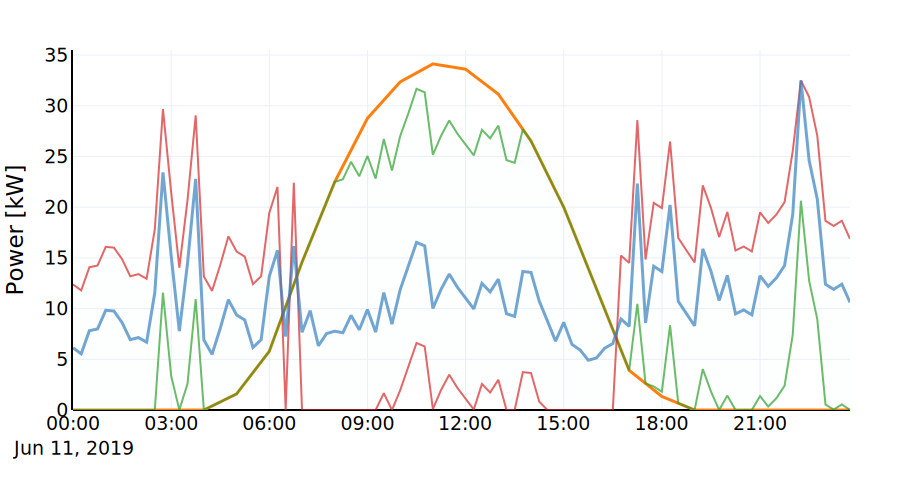

In [20]:
graph = df[["community_kW"]].copy()
graph.columns = ["Load profile NSS=50%"]
for frame, target in zip([results[0]["profile"].copy(), results[1]["profile"].copy()], [20, 80]):
    graph[f"Profile with NSS={int(target)}%"] = frame["profile"]
graph["Solar production"] = df["pv_1kw"] * breakpoint_pv
graph = graph[graph.columns[::-1]]
    
fig = px.line(graph)
fig.data[3].update(line_width=3, opacity=0.7, line_color="rgba(55, 128, 191, 1.0)", line_dash="solid")
fig.data[2].update(line_width=2, line_color="rgba(214, 39, 40, 0.7)", fill="tonexty", fillcolor="rgba(55, 128, 191, 0.01)")
fig.data[1].update(line_width=2, line_color="rgba(44, 160, 44, 0.7)")
fig.data[0].update(line_width=3, line_color="rgba(255, 127, 14, 1.0)") #rgba(188, 189, 34, 1.0) rgba(0, 0, 0, 0.7)
fig.update_layout(
    layout,
    height=500,
    width=900,
    legend={"x": 0.64, "y": 1.03},
    xaxis={"title": "", "tickangle": 0, "color": "black",
           "showline": False, "linecolor": "black", "linewidth": 2},
    yaxis={"title": "Power [kW]", "color": "black", "range": [0, 35.5],
           "showline": True, "linecolor": "black", "linewidth": 2},
    legend_title="",
    showlegend=False)
fig.show()

blue line is at NSS=42.06%

In [136]:
fig.write_image("results/illustration_NSS.svg")